In [122]:
import pandas as pd
from tqdm import tqdm

In [123]:
import random

def random_model(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["logit_0"] = pd.Series([random.uniform(-1, 1) for _ in range(len(df))])
    df["logit_1"] = pd.Series([random.uniform(-1, 1) for _ in range(len(df))])
    return df

In [124]:
df = pd.read_pickle("../results/predictions_finetuned_2e-5_bs32_e3_best.pkl")
# df = random_model(df)
print(len(df))
df.head()


1532682


,book_path,chapter_idx,paragraph_idx,labels,logit_0,logit_1
0,riehl_ovidhofe.json,0,1,1,-3.513684,2.484013
1,riehl_ovidhofe.json,0,2,1,-4.145504,2.869292
2,riehl_ovidhofe.json,0,3,1,-1.776233,1.367002
3,riehl_ovidhofe.json,0,4,1,-4.529003,3.121587
4,riehl_ovidhofe.json,0,5,1,-3.214940,2.548427


In [125]:
def add_predictions(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df["top_n_prediction"] = pd.Series([True for _ in range(len(df))])
    for book in tqdm(df["book_path"].unique()):
        book_df = df[df["book_path"] == book]
        predicted_chapters = book_df.sort_values("logit_0", ascending=False)[
            : len(book_df[book_df["labels"] == 0])
        ]
        for row in predicted_chapters.iterrows():
            df.loc[row[0], "top_n_prediction"] = False  # chapter break is class 0
    # df["local_prediction"] = pd.Series([True for _ in range(len(df))])
    # for idx, row in df.iterrows():
    #     df.loc[idx, "local_prediction"] = row["logit_0"] < row["logit_1"]
    df["local_prediction"] = df["logit_0"] < df["logit_1"]
    df["threshold_prediction"] = (pred_df["logit_0"] - pred_df["logit_0"].min())/(pred_df["logit_0"].max() - pred_df["logit_0"].min()) <= 0.9

    return df

pred_df = add_predictions(df)
pred_df.head()

100%|██████████| 1188/1188 [01:45<00:00, 11.25it/s]


,book_path,chapter_idx,paragraph_idx,labels,logit_0,logit_1,top_n_prediction,local_prediction,threshold_prediction
0,riehl_ovidhofe.json,0,1,1,-3.513684,2.484013,True,True,True
1,riehl_ovidhofe.json,0,2,1,-4.145504,2.869292,True,True,True
2,riehl_ovidhofe.json,0,3,1,-1.776233,1.367002,True,True,True
3,riehl_ovidhofe.json,0,4,1,-4.529003,3.121587,True,True,True
4,riehl_ovidhofe.json,0,5,1,-3.214940,2.548427,True,True,True


In [132]:
import json
from sklearn.metrics import f1_score
from nltk.metrics import segmentation

def calc_f1_score(df: pd.DataFrame, prediction_column: str) -> float:
    # class 0 (chapter break) is relevant for us
    return f1_score(
        df["labels"].replace([1, 0], value=[False, True]),
        df[prediction_column].replace([True, False], value=[False, True]),
    )


def calc_pk_wd(df: pd.DataFrame, prediction_column: str) -> tuple:
    # class 0 (no continuation) should denote chapter break, metrics assume 1
    labels = df["labels"].replace([1, 0], value=[0, 1])
    predictions = df[prediction_column].replace([True, False], value=[0, 1])
    labels = "".join(map(str, labels))
    predictions = "".join(map(str, predictions))
    # k should be half average reference segment length
    # average paragraph count per chapter is ~54
    # median is 32
    k = int(round(len(labels) / (labels.count("1") * 2.0)))
    pk = segmentation.pk(labels, predictions, k=k)
    windowdiff = segmentation.windowdiff(labels, predictions, k=k)
    return pk, windowdiff

def calculate_metrics(df: pd.DataFrame, prediction_column: str) -> pd.DataFrame:
    results = []
    for book in tqdm(df["book_path"].unique()):
        book_df = df[df["book_path"] == book]
        f1 = calc_f1_score(book_df, prediction_column)
        pk, windowdiff = calc_pk_wd(book_df, prediction_column)
        with open(f"../corpus/{book}", "r") as f:
            genre = json.load(f)["genre"]
        results.append({"book": book, "f1": f1, "pk": pk, "wd": windowdiff, "genre": genre})
    return pd.DataFrame(results)

In [133]:
top_n_df = calculate_metrics(pred_df, "top_n_prediction")
print(top_n_df.head())

print("Micro-averaged F1: ", top_n_df["f1"].mean())
print("Micro-averaged PK: ", top_n_df["pk"].mean())
print("Micro-averaged WD: ", top_n_df["wd"].mean())

100%|██████████| 1188/1188 [01:47<00:00, 11.03it/s]

                     book        f1        pk        wd  \
0     riehl_ovidhofe.json  0.400000  0.367424  0.522727   
1   dumasalt_margot2.json  0.500000  0.332512  0.392969   
2  liebernt_knutarne.json  0.562500  0.240924  0.308345   
3   wulffen_argobast.json  0.666667  0.193755  0.266467   
4      verne_ferien2.json  0.928571  0.073394  0.073394   

                                genre  
0    Romane, Novellen und Erzählungen  
1  Historische Romane und Erzählungen  
2    Romane, Novellen und Erzählungen  
3    Romane, Novellen und Erzählungen  
4    Romane, Novellen und Erzählungen  
Micro-averaged F1:  0.5068725074474271
Micro-averaged PK:  0.27070962159394824
Micro-averaged WD:  0.33051275784987116


In [134]:
genre_grouped = top_n_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Romane, Novellen und Erzählungen",0.490448,0.276473,0.337452,852
"Krimis, Thriller, Spionage",0.485029,0.304755,0.359000,71
Historische Romane und Erzählungen,0.484475,0.291250,0.349775,65
"Märchen, Sagen, Legenden",0.742161,0.145684,0.190550,52
Kinderbücher ab 12 Jahren,0.566361,0.263879,0.321053,42
"Humor, Satire",0.638820,0.177778,0.245307,40
Spannung und Abenteuer,0.432700,0.332765,0.388104,19
Phantastische Literatur,0.447005,0.289703,0.360368,16
Romanhafte Biographien,0.402213,0.318070,0.375424,13


In [135]:
local_df = calculate_metrics(pred_df, "local_prediction")
local_df.head()

print("Micro-averaged F1: ", local_df["f1"].mean())
print("Micro-averaged PK: ", local_df["pk"].mean())
print("Micro-averaged WD: ", local_df["wd"].mean())

100%|██████████| 1188/1188 [01:46<00:00, 11.12it/s]

Micro-averaged F1:  0.26265731936000614
Micro-averaged PK:  0.43404407678190116
Micro-averaged WD:  0.8219959280988912


In [136]:
genre_grouped = local_df.groupby(["genre"])
f1 = genre_grouped["f1"].mean()
pk = genre_grouped["pk"].mean()
wd = genre_grouped["wd"].mean()
count = genre_grouped["book"].count()
result = pd.concat([f1, pk, wd, count], axis=1).rename(columns={"book": "count"})
result.sort_values(by="count", ascending=False)

,f1,pk,wd,count
genre,,,,
"Romane, Novellen und Erzählungen",0.251633,0.438066,0.828459,852
"Krimis, Thriller, Spionage",0.238893,0.436571,0.844860,71
Historische Romane und Erzählungen,0.234289,0.447706,0.872362,65
"Märchen, Sagen, Legenden",0.446305,0.374292,0.664472,52
Kinderbücher ab 12 Jahren,0.284126,0.425316,0.827569,42
"Humor, Satire",0.393671,0.360234,0.669765,40
Spannung und Abenteuer,0.229692,0.450886,0.859735,19
Phantastische Literatur,0.215858,0.472918,0.901665,16
Romanhafte Biographien,0.153052,0.498981,0.942654,13


In [137]:
threshold_df = calculate_metrics(pred_df, "threshold_prediction")
print(threshold_df.head())

print("Micro-averaged F1: ", threshold_df["f1"].mean())
print("Micro-averaged PK: ", threshold_df["pk"].mean())
print("Micro-averaged WD: ", threshold_df["wd"].mean())

100%|██████████| 1188/1188 [01:46<00:00, 11.13it/s]

                     book        f1        pk        wd  \
0     riehl_ovidhofe.json  0.333333  0.439394  0.439394   
1   dumasalt_margot2.json  0.057143  0.488580  0.488580   
2  liebernt_knutarne.json  0.111111  0.361622  0.361622   
3   wulffen_argobast.json  0.312500  0.405475  0.411891   
4      verne_ferien2.json  0.965517  0.036697  0.036697   

                                genre  
0    Romane, Novellen und Erzählungen  
1  Historische Romane und Erzählungen  
2    Romane, Novellen und Erzählungen  
3    Romane, Novellen und Erzählungen  
4    Romane, Novellen und Erzählungen  
Micro-averaged F1:  0.26489234174632664
Micro-averaged PK:  0.3800817557520989
Micro-averaged WD:  0.39407427527266614


In [145]:
import matplotlib.pyplot as plt
import math
import numpy as np

def plot_book(dataframe: pd.DataFrame, book_id=None, fig_size=(20, 5), column="top_n_prediction"):
    book_id = book_id
    if book_id == None:
        book_id = random.choice(dataframe["book_path"])
    book_df = dataframe[dataframe["book_path"] == book_id]
    book_df.index = [i - min(book_df.index) for i in book_df.index]

    if column == "log_prediction":
        normalized_logit_0 = (book_df["logit_0"] - book_df["logit_0"].min())/(book_df["logit_0"].max() - book_df["logit_0"].min())
        indices = np.where(np.array(normalized_logit_0) > 0.9)[0]
        candidates = book_df.iloc[indices]
    else:
      candidates = book_df[book_df[column] == False]

    plt.figure(figsize=fig_size)
    plt.title(f"BERT-predicted chapter breaks - {book_id}")
    plt.xlabel("Paragraph")
    plt.ylabel("BERT confidence score")
    if column == "log_prediction":
        plt.scatter(book_df.index, normalized_logit_0, s=5)
        plt.scatter(candidates.index, np.array(normalized_logit_0)[indices], c="red", marker="s")
    else:
        plt.scatter(book_df.index, book_df["logit_0"], s=5)
        plt.scatter(candidates.index, candidates["logit_0"], c="red", marker="s")
    xcoords = book_df[book_df["labels"] == 0].index
    for x in xcoords:
        plt.axvline(x, c="green")
    plt.show()

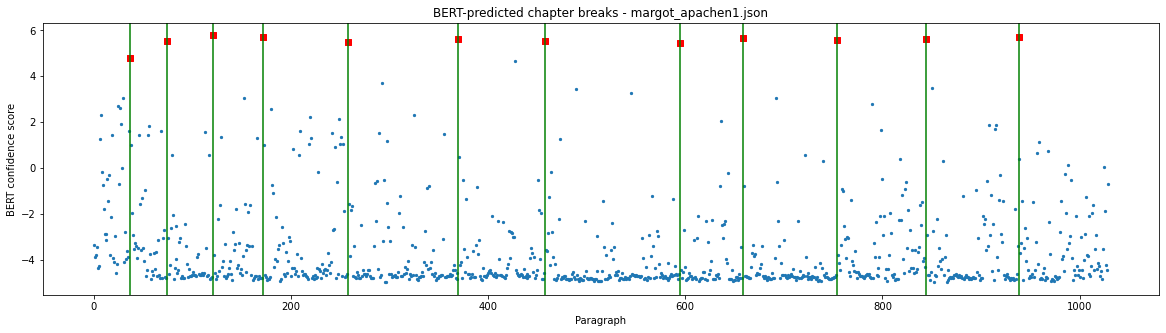

In [139]:
# potentially interesting examples:
# * margot_apachen1.json (perfect prediction)
# * may_baerenj.json (clustered predictions with peaks on chapter breaks)
# * lagerloe_christus.json (anthology w/ some multi-chapter stories inside)
plot_book(pred_df, "margot_apachen1.json", column="top_n_prediction")

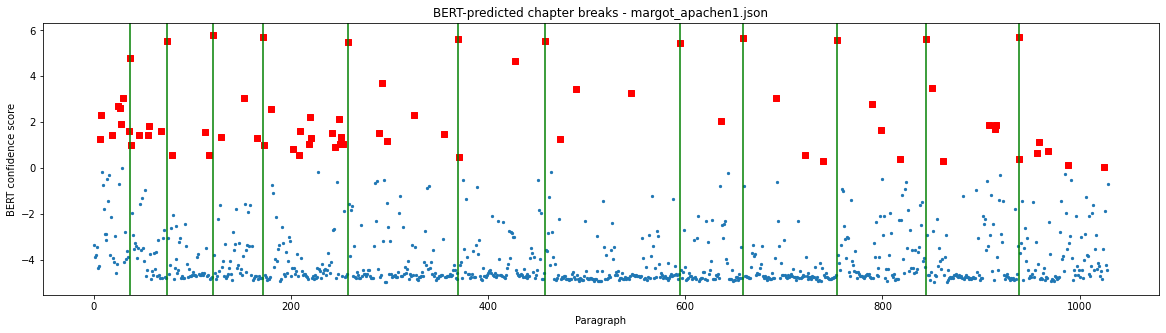

In [140]:
plot_book(pred_df, "margot_apachen1.json", column="local_prediction")

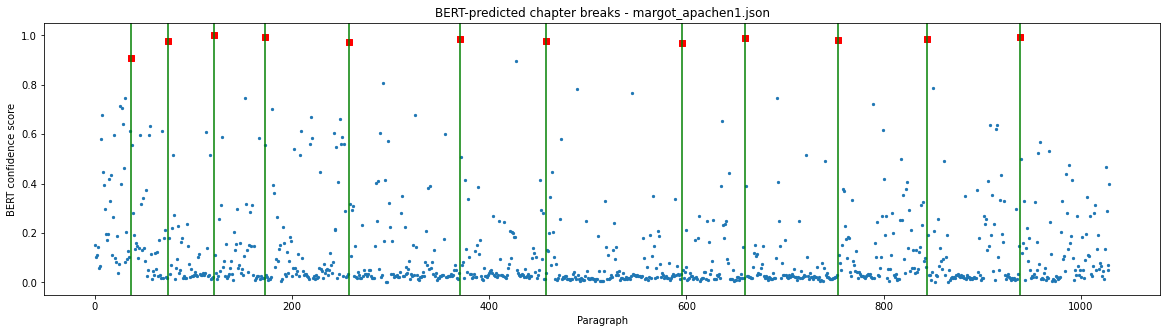

In [146]:
plot_book(pred_df, "margot_apachen1.json", column="log_prediction")

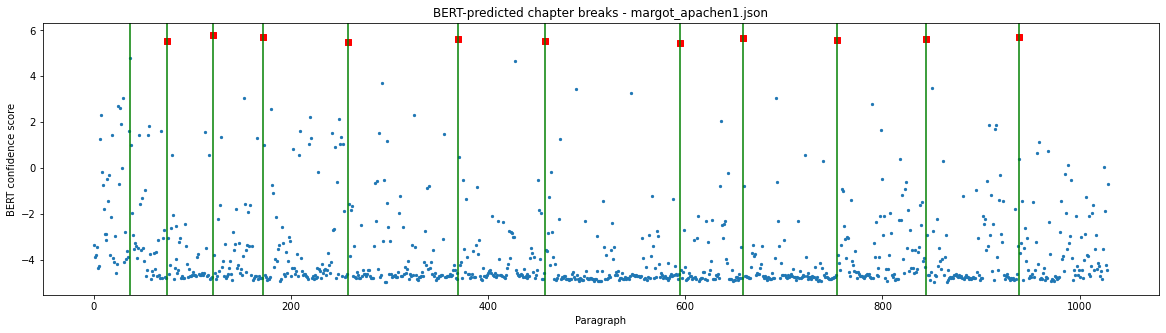

In [147]:
plot_book(pred_df, "margot_apachen1.json", column="threshold_prediction")